In [ ]:
mkdir -p ./QUILT/package_2021_01_15A/
cp -r /home/jupyter-bgi23_siyang/software/QUILT/package_2021_01_15A/* ./QUILT/package_2021_01_15A/
cd QUILT

In [ ]:
/home/jupyter-bgi23_siyang/software/QUILT/QUILT.R -h

# Input formats
Input Reference panel. IMPUTE format hap and legend format files with reference haplotypes. These can be made from haplotype VCFs using bcftools convert --haplegendsample. Alternatively, they can be made manually. The haplotype file is a gzipped file with no header and no rownames, with one row per SNP, with one column per reference haplotype, space separated, and values of 0 (ref) and 1 (alt). The legend file is a gzipped file with no rownames, a header file including position for the physical position in 1 based coordinates, a0 for the reference allele, and a1 for the alternate allele. An optional sample file and file with samples to exclude can be useful for changing who is used in the reference panel.

Genetic map. File with genetic map information, with 3 white-space delimited columns giving position (1-based), genetic rate map in cM/Mbp, and genetic map in cM

Bams. Given as a bamlist (i.e. a file with one row per sample, the path to the bam)

(Optional) Truth data. phasefile and posfile. Useful for understanding performance. Phasefile has a header row with a name for each sample, matching what is found in the bam file. File is tab separated, one subject per column, with 0 = ref and 1 = alt, separated by a vertical bar |, e.g. 0|0 or 0|1. Note therefore this file has one more row than posfile which has no header. For posfile, this is a file with positions of where to impute, lining up one-to-one with the SNPs of phasefile. File is tab seperated with no header, one row per SNP, with col 1 = chromosome, col 2 = physical position (sorted from smallest to largest), col 3 = reference base, col 4 = alternate base. Bases are capitalized. Example first row: 11000AG

In [ ]:
cat ./package_2021_01_15A/bamlist.1.0.txt

In [ ]:
#reference_haplotype_file
zcat ./package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.noNA12878.hap.gz|head -n 5

In [ ]:
#reference_legend_file
zcat ./package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.noNA12878.legend.gz|head -n 5

In [ ]:
#genetic_map_file
zcat ./package_2021_01_15A/CEU-chr20-final.b38.txt.gz|head -n 5

In [ ]:
#Run QUILT

rm -r -f quilt_output
/home/jupyter-bgi23_siyang/software/QUILT/QUILT.R  \
--outputdir=quilt_output \
--chr=chr20 \
--regionStart=2000001 \
--regionEnd=2100000 \
--buffer=10000 \
--bamlist=package_2021_01_15A/bamlist.1.0.txt \
--posfile=package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.posfile.txt \
--phasefile=package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.phasefile.txt \
--reference_haplotype_file=package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.noNA12878.hap.gz \
--reference_legend_file=package_2021_01_15A/ALL.chr20_GRCh38.genotypes.20170504.chr20.2000001.2100000.noNA12878.legend.gz \
--genetic_map_file=package_2021_01_15A/CEU-chr20-final.b38.txt.gz \
--nGen=100 \
--save_prepared_reference=TRUE

# output formats
Output VCF with both SNP annotation information (see below) and per-sample genotype information. Per-sample genotype information includes the following entries

GT Phased genotypes Phased genotype, where each allele is the rounded per-haplotype posterior probability (HD below)

GP Genotype posteriors Posterior probabilities of the three genotypes given the data

DS Diploid dosage Posterior expectation of the diploid genotype i.e. the expected number of copies of the alternate allele

HD Haploid dosages Per-haplotype posterior probability of an alternate allele

Note that in QUILT, genotype posteriors (GP) and dosages (DS) are taken from the main Gibbs sampling, while the phasing results (GT and HD) are taken from an additional special phasing Gibbs sample. As such, phasing results (GT and HD) might not be consistent with genotype information (GP and DS). If consistency is necessary, note that you can create a consistent GP and DS from HD.

In [11]:
cd ~/QUILT/quilt_output
zcat quilt.chr20.2000001.2100000.vcf.gz|head -n 20

##fileformat=VCFv4.0
##INFO=<ID=INFO_SCORE,Number=.,Type=Float,Description="Info score">
##INFO=<ID=EAF,Number=.,Type=Float,Description="Estimated allele frequency">
##INFO=<ID=HWE,Number=.,Type=Float,Description="Hardy-Weinberg p-value">
##INFO=<ID=ERC,Number=.,Type=Float,Description="Estimated number of copies of the reference allele from the pileup">
##INFO=<ID=EAC,Number=.,Type=Float,Description="Estimated number of copies of the alternate allele from the pileup">
##INFO=<ID=PAF,Number=.,Type=Float,Description="Estimated allele frequency using the pileup of reference and alternate alleles">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Phased genotypes">
##FORMAT=<ID=GP,Number=3,Type=Float,Description="Posterior genotype probability of 0/0, 0/1, and 1/1">
##FORMAT=<ID=DS,Number=1,Type=Float,Description="Diploid dosage">
##FORMAT=<ID=HD,Number=2,Type=Float,Description="Haploid dosages">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	NA12878HT	NA12878ONT	NA12878
chr20	2000004	.	C	

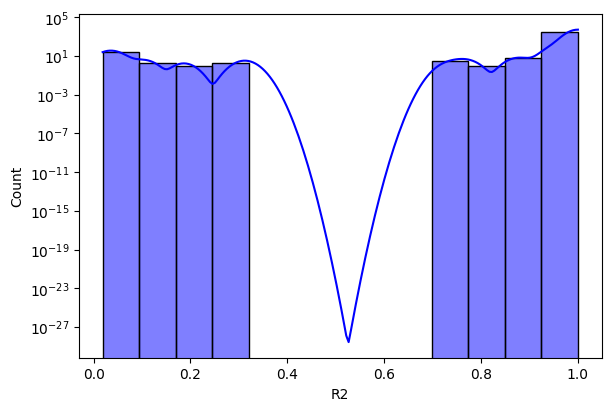

In [21]:
#INFO_sorce
#Visualize distribution of the MACH R2 
import sys
import gzip
import re
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns


if __name__ == "__main__":
    in_fname = os.path.expanduser("~")+"/QUILT/quilt_output/quilt.chr20.2000001.2100000.vcf.gz"

    data = []
    with gzip.open(in_fname, "rt") if in_fname.endswith(".gz") else open(in_fname) as f:
        for line in f:
            if line.startswith("#"):
                continue

            col = line.strip().split()

            # af = float(re.search(";?AF=([^;]+)", col[7]).group(1))
            m = re.search(";?INFO_SCORE=([^;]+)", col[7])
            if m:
                r2 = float(m.group(1))
                data.append(r2)


    df = pd.DataFrame({"R2": data})

    f, ax = plt.subplots(1,1,figsize=(6, 4), constrained_layout=True)
    sns.histplot(data=df[df["R2"]!=0], x="R2", kde=True, color="b", ax=ax)
    ax.set_yscale("log")
    plt.show()


In [19]:
pwd

/home/jupyter-bgi23s22/QUILT/quilt_output
